# Gesture Recognition Case Study


## Problem Statement

To develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

## Understanding the Dataset

* The training data consists of a few hundred videos categorised into one of the five classes.
* Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images).
* These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.
* The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images).
* All images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types*  of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). So some pre-processing is required to standardise the videos.
* Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.



## Goal

The task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). There is the test folder for evaluation purposes - the final model's performance will be tested on the 'test' set.

### Load required libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
#!pip install scikit-image
import skimage
from skimage import data, color
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
import datetime
import os
import abc
from abc import ABCMeta

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

### set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Clean-up old model directories

In [ ]:
!rm -rf /content/drive/MyDrive/conv*

In [ ]:
!unzip "/content/drive/MyDrive/Project_data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00029.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00031.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00033.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00035.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00037.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00039.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00041.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00043.png  
 extracting: Project_data/train/WIN_20180926_17_33_08

 ### Read the folder names for training and validation and setting the batch size here.

In [ ]:
train_doc = np.random.permutation(open("Project_data/train.csv").readlines())
val_doc = np.random.permutation(open("Project_data/val.csv").readlines())
batch_size = 32 #experiment with the batch size


### Cheking No. of train and test sequence

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


### Creating ModelClass to support

*  All the initialisations of paths, image properties and model properties
*  Generator function for generating the data with labels
    * The images will be cropped to the size we want
    * The images with irregular dimension will be center cropped on the x-axis equally on both sides
    * We save the model only when the validation loss decreases
    * Learning rate decreases when approaching the minima
*  An abstract method to define our own model by inheriting this class
*  A generic train functionl.
*  Plotting the model

In [ ]:
class ModelClass(metaclass= ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder_path):
        self.train_doc = np.random.permutation(open(project_folder_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder_path + '/' + 'val.csv').readlines())
        self.train_path = project_folder_path + '/' + 'train'
        self.val_path =  project_folder_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties
    def initialize_image_properties(self,image_height=120,image_width=120):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=32,num_epochs=50):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def initialize_modelparams(self):
        self.model = None
        self.history = None

    def generator(self,source_path, folder_list, model_type = "Conv3D"):
      if model_type == "Conv3D":
        img_idx = [rn.randint(0, self.total_frames-1) for i in range(self.frames_to_sample)] #create a list of image numbers you want to use for a particular video
      else:
        img_idx = [i for i in range(self.frames_to_sample)] ## CNN+GRU
      # print(img_idx)
      while True:
          t = np.random.permutation(folder_list)
          num_batches = len(folder_list)//self.batch_size # calculate the number of batches
          for batch_no in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((self.batch_size,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((self.batch_size,self.num_classes)) # batch_labels is the one hot representation of the output
              for folder in range(self.batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch_no*self.batch_size)].split(';')[0]) # read all the images in the folder
                  # print("imgs: ",imgs)
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch_no*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape == (360,360,3): ###if images are of 360 x 360
                        #image = imresize(image,(self.image_height,self.image_width,self.channels))
                        #skimage.transform.resize(image,(y,z))
                        image = skimage.transform.resize(image,(self.image_height,self.image_width,self.channels))
                      else:
                        image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                      #crop the images and resize them. Note that the images are of 2 different shape
                      #and the conv3D will throw error if the inputs in a batch have different shapes


                      batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image

                  batch_labels[folder, int(t[folder + (batch_no*self.batch_size)].strip().split(';')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


      #     write the code for the remaining data points which are left after full batches
          left_images = len(folder_list)%self.batch_size
          left_overs = t[len(t)-left_images:]

          batch_data = np.zeros((left_images,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((left_images,self.num_classes)) # batch_labels is the one hot representation of the output
          for folder in range(left_images): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ left_overs[folder].split(';')[0]) # read all the images in the folder
              # print("imgs: ",imgs)
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ left_overs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  if image.shape == (360,360,3): ###if images are of 360 x 360
                        #image = imresize(image,(self.image_height,self.image_width,self.channels))
                        #skimage.transform.resize
                        image = skimage.transform.resize(image,(self.image_height,self.image_width,self.channels))
                  else:
                    image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                  #crop the images and resize them. Note that the images are of 2 different shape
                  #and the conv3D will throw error if the inputs in a batch have different shapes


                  batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image

              batch_labels[folder, int(left_overs[folder].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    @abc.abstractmethod
    def model_architecture(self):
      pass

    def train_model(self,model,model_name="model_init",model_type="Conv3D"):
        train_generator = self.generator(self.train_path, self.train_doc,model_type=model_type)
        val_generator = self.generator(self.val_path, self.val_doc,model_type=model_type)

        model_name = model_name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = "/content/drive/MyDrive/"+model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

       #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        #callbacks_list = [checkpoint, LR, earlystop]
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.history = history
        return history

    def plot_model(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])
        plt.title('model loss')

        axes[1].plot(self.history.history['categorical_accuracy'])
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
        plt.title('model accuracy')

### Sample image cropping

(120, 160, 3)


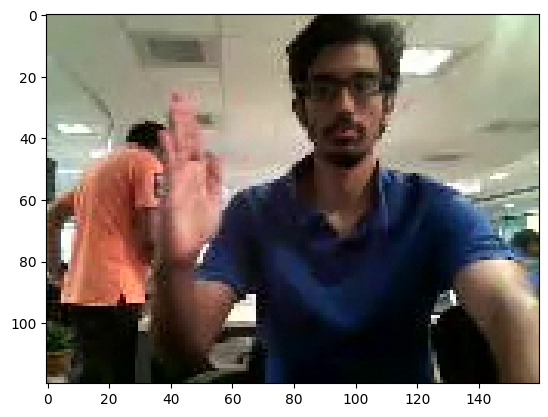

In [ ]:
image = imread('Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00055.png')
print(image.shape)
plt.imshow(image/255)

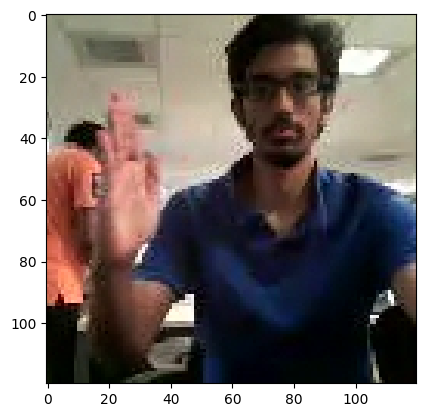

In [ ]:
##centre cropping of the image looks like this for a (120,160) image
image = image[:,20:140]
plt.imshow(image)
plt.show()

### Model Buiding
#### We will create Conv3D Models having different parameters and choose the best one depending on the result


In [ ]:
#defining the project folder path
project_folder_path = "/content/Project_data"

#### Model 1
  * Frames = 15
  * Batch size = 32
  * Images cropped to 120,120
  * 128 dense neurons in the two dense layers
  * Epochs = 20
  * Dropout = 0.25


In [ ]:
class Conv3D1(ModelClass):

    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D1 = Conv3D1()
conv3D1.initialize_path(project_folder_path)
conv3D1.initialize_image_properties(image_height=120,image_width=120)
conv3D1.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D1.initialize_modelparams()
conv3D1_model=conv3D1.model_architecture(dense_neurons=128,dropout=0.25)
conv3D1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 15, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 60, 60, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     4

In [ ]:
##train the model
conv3D1.train_model(conv3D1_model,model_name="conv3D1",model_type="Conv3D")

<ipython-input-20-d9486b721876>:124: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6200 - categorical_accuracy: 0.4223
Epoch 1: val_loss improved from inf to 1.93481, saving model to /content/drive/MyDrive/conv3D1_2024-02-0308_02_18.075846/model-00001-1.62004-0.42232-1.93481-0.22000.h5
21/21 [==============================] - 85s 4s/step - loss: 1.6200 - categorical_accuracy: 0.4223 - val_loss: 1.9348 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.8469 - categorical_accuracy: 0.6938
Epoch 2: val_loss did not improve from 1.93481
21/21 [==============================] - 74s 4s/step - loss: 0.8469 - categorical_accuracy: 0.6938 - val_loss: 2.5087 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5551 - categorical_accuracy: 0.7843
Epoch 3: val_loss did not improve from 1.93481
21/21 [==============================] - 72s 4s/step - loss: 0.5551 - categorical_accuracy: 0.7843 - val_loss: 3.0685 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - ETA: 0s - loss: 0.3732 - categorical_accuracy: 0.8793
Epoch 4: val_loss did not improve from 1.93481
21/21 [==============================] - 67s 3s/step - loss: 0.3732 - categorical_accuracy: 0.8793 - val_loss: 4.0088 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - ET

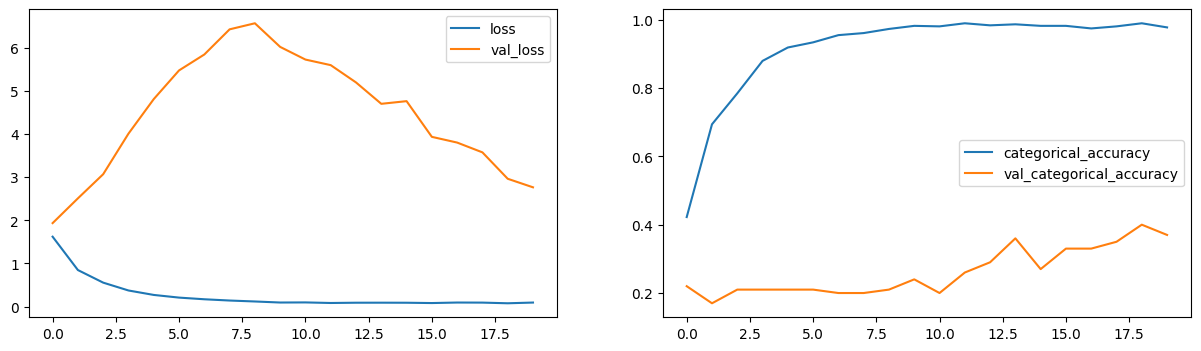

In [ ]:
# plot the model
conv3D1.plot_model()

##### Summary on model 1 performance:

* The model clearly overfits. The train accuracy is in the range of 90% whereas the validation accuracy is in the range of 30%



#### Model 2

  * Frames = 20
  * Batch size = 20
  * Images cropped to 120,120
  * 128 dense neurons in the two dense layers
  * Epochs = 30

In [ ]:
conv3D2 = Conv3D1()
conv3D2.initialize_path(project_folder_path)
conv3D2.initialize_image_properties(image_height=120,image_width=120)
conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv3D2.initialize_modelparams()
conv3D2_model=conv3D2.model_architecture(dense_neurons=128,dropout=0.25)
conv3D2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)   

In [ ]:
##train the model
conv3D2.train_model(conv3D2_model,model_name="conv3D2",model_type="Conv3D")

<ipython-input-20-d9486b721876>:124: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.5588 - categorical_accuracy: 0.4540
Epoch 1: val_loss improved from inf to 4.26607, saving model to /content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00001-1.55878-0.45400-4.26607-0.21000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.5588 - categorical_accuracy: 0.4540 - val_loss: 4.2661 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.9419 - categorical_accuracy: 0.6290
Epoch 2: val_loss did not improve from 4.26607
34/34 [==============================] - 89s 3s/step - loss: 0.9419 - categorical_accuracy: 0.6290 - val_loss: 8.2928 - val_categorical_accuracy: 0.2125 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7147 - categorical_accuracy: 0.7360
Epoch 3: val_loss did not improve from 4.26607
34/34 [==============================] - 89s 3s/step - loss: 0.7147 - categorical_accur

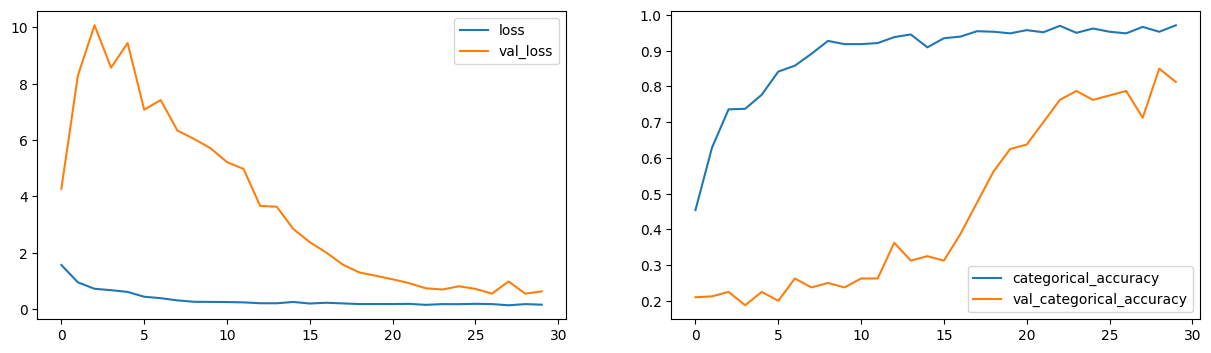

In [ ]:
# plot the model
conv3D2.plot_model()

#### Summary on Model 2 performance:

* The validation accuracy increased to ~80% and is improved compared to Model 1
* There is still good amount of difference between train and validation accuracy.

Let's do some further experiments on the parameters



#### Model 3:

  * 20 frames to be sampled
  * batch size of 16 (perviously 20)
  * Images cropped to 120,120
  * 128 dense neurons in the two dense layers
  * Epochs = 30
  * dropout = 0.5

In [ ]:
conv3D3 = Conv3D1()
conv3D3.initialize_path(project_folder_path)
conv3D3.initialize_image_properties(image_height=120,image_width=120)
conv3D3.initialize_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D3.initialize_modelparams()
conv3D3_model=conv3D3.model_architecture(dense_neurons=128,dropout=0.5)
conv3D3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_8 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 20, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)   

In [ ]:
#train the model
conv3D3.train_model(conv3D3_model,model_name="conv3D3",model_type="Conv3D")

<ipython-input-20-d9486b721876>:124: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8721 - categorical_accuracy: 0.3635
Epoch 1: val_loss improved from inf to 3.77866, saving model to /content/drive/MyDrive/conv3D3_2024-02-0309_15_57.333034/model-00001-1.87213-0.36350-3.77866-0.21000.h5
42/42 [==============================] - 104s 2s/step - loss: 1.8721 - categorical_accuracy: 0.3635 - val_loss: 3.7787 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.4128 - categorical_accuracy: 0.5023
Epoch 2: val_loss did not improve from 3.77866
42/42 [==============================] - 96s 2s/step - loss: 1.4128 - categorical_accuracy: 0.5023 - val_loss: 5.8655 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1528 - categorical_accuracy: 0.5897
Epoch 3: val_loss did not improve from 3.77866
42/42 [==============================] - 94s 2s/step - loss: 1.1528 - categorical_accur

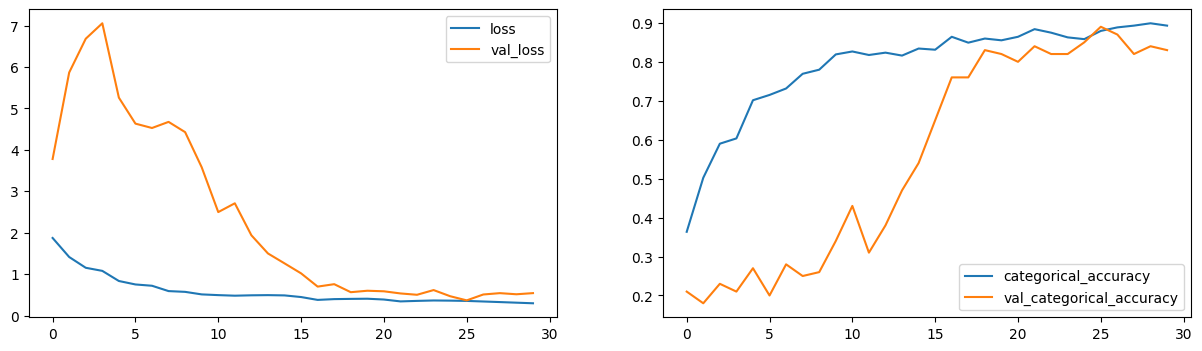

In [ ]:
conv3D3.plot_model()

#### Summary on Model 3 performance:

* The gap between train and validation accuracy reduced significantly, so overfitting issue is almost resolved
* This is the best model so far

Let's try a few more models like above using different kernel size

#### Model 4

  * 15 frames to be sampled
  * batch size of 20
  * Images cropped to 120,120
  * 128 dense neurons in the two dense layers
  * Epochs = 40
  * dropout = 0.25
  * kernel size = (2,2,2)

In [ ]:
class Conv3D4(ModelClass):

    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(256, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(512, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D4 = Conv3D4()
conv3D4.initialize_path(project_folder_path)
conv3D4.initialize_image_properties(image_height=120,image_width=120)
conv3D4.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=40)
conv3D4.initialize_modelparams()
conv3D4_model=conv3D4.model_architecture(dense_neurons=128,dropout=0.25)
conv3D4_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 15, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 15, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 7, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 60, 60, 32)    

In [ ]:
##train the model
conv3D4.train_model(conv3D4_model,model_name="conv3D4",model_type="Conv3D")

<ipython-input-20-d9486b721876>:124: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.6988 - categorical_accuracy: 0.3499
Epoch 1: val_loss improved from inf to 1.72450, saving model to /content/drive/MyDrive/conv3D4_2024-02-0310_03_44.962169/model-00001-1.69879-0.34992-1.72450-0.16000.h5
34/34 [==============================] - 88s 2s/step - loss: 1.6988 - categorical_accuracy: 0.3499 - val_loss: 1.7245 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.3935 - categorical_accuracy: 0.4495
Epoch 2: val_loss did not improve from 1.72450
34/34 [==============================] - 76s 2s/step - loss: 1.3935 - categorical_accuracy: 0.4495 - val_loss: 2.3401 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.1985 - categorical_accuracy: 0.5354
Epoch 3: val_loss did not improve from 1.72450
34/34 [==============================] - 69s 2s/step - loss: 1.1985 - categorical_accura

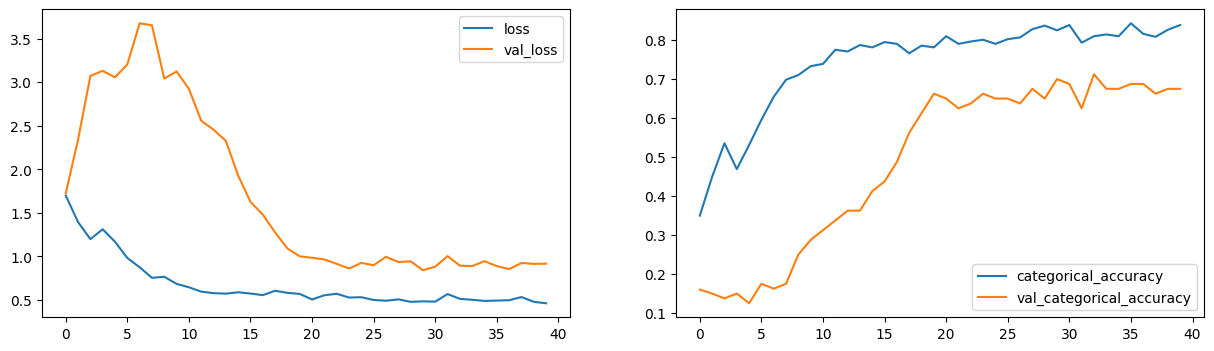

In [ ]:
conv3D4.plot_model()

#### Summary on Model 4 performance:

  * This model performance is not good as Model 3 and it is showing overfitting isse as there is gap between training and validation accuracy


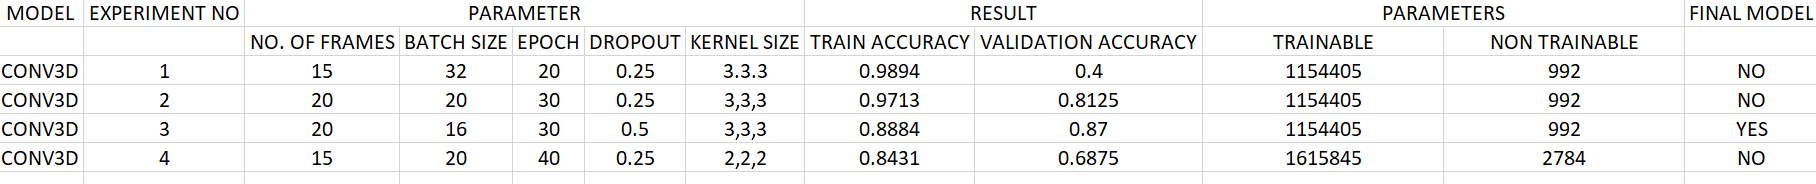

#### Check how many models have been saved

In [ ]:
!ls  /content/drive/MyDrive/conv*/*.h5

/content/drive/MyDrive/conv3D1_2024-02-0308_02_18.075846/model-00001-1.62004-0.42232-1.93481-0.22000.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00001-1.55878-0.45400-4.26607-0.21000.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00013-0.20060-0.93816-3.65745-0.36250.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00014-0.19959-0.94570-3.62932-0.31250.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00015-0.24568-0.90950-2.83865-0.32500.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00016-0.19115-0.93514-2.36680-0.31250.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00017-0.21803-0.93967-1.99751-0.38750.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00018-0.19464-0.95475-1.56838-0.47500.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-00019-0.17122-0.95324-1.29250-0.56250.h5
/content/drive/MyDrive/conv3D2_2024-02-0308_30_21.711541/model-0

#### Load the best model

In [ ]:
import time
from keras.models import load_model
model = load_model('/content/drive/MyDrive/conv3D3_2024-02-0309_15_57.333034/model-00025-0.35939-0.85822-0.46618-0.85000.h5')


In [ ]:
test_generator=Conv3D1()
#test_generator = conv3D3_model()
test_generator.initialize_path(project_folder_path)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=30)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,model_type="Conv3D")
batch_data, batch_labels=next(g)


In [ ]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [59]:
# get the prediction
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)) ## predicted labels

1/1 [==============================] - 0s 103ms/step
[1 2 1 3 0 3 4 3 0 3 3 0 4 4 1 0]
